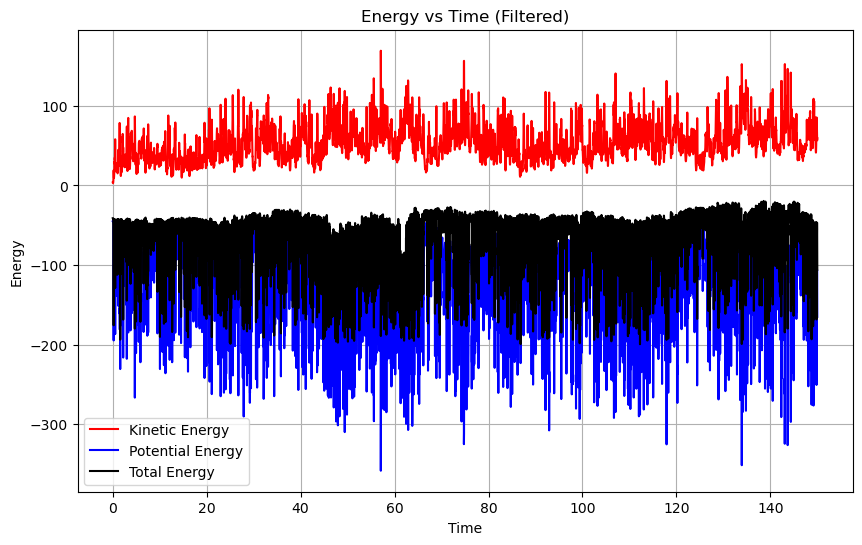

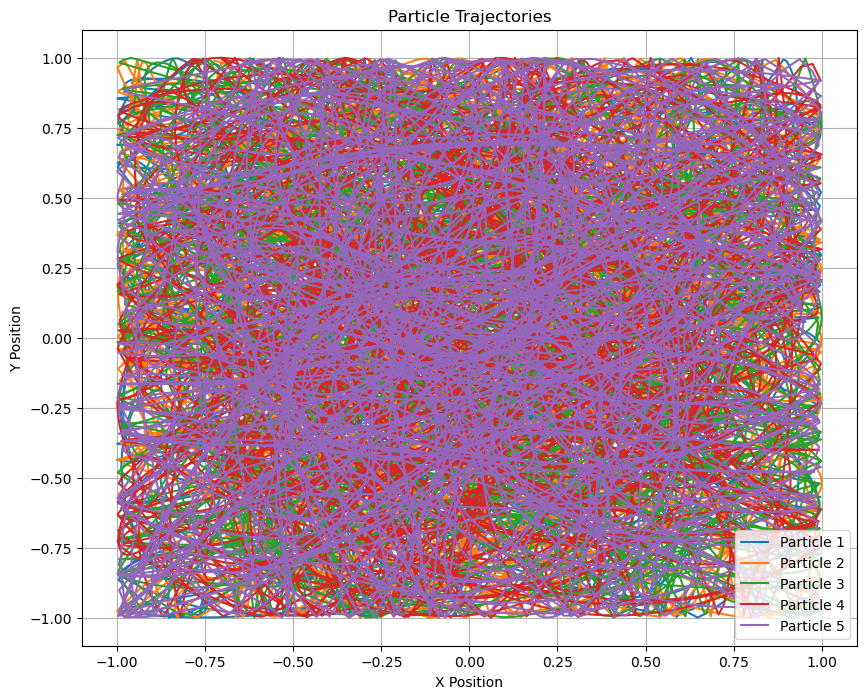

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import utils as ut
import importlib

importlib.reload(ut)

seed_value = 42

N = 5  # Number of particles
tEnd = 150.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.15  # softening length
G = 1.0  # Newton's Gravitational Constant
boxSize = 1.0
mass_coef = 10.0
dims = 2

hparams = {
    'N': N,  # Number of particles
    'tEnd': tEnd,  # Time at which simulation ends
    'dt': dt,  # Timestep
    'G': G,  # Newton's Gravitational Constant
    'boxSize': boxSize,  # Size of the simulation box
    'mass_coef': mass_coef  # Mass coefficient
}

combined_data = ut.simulate_gravitational_system(seed_value, N, tEnd, dt, softening, G, boxSize, mass_coef, dims=dims, init_boxsize=1)


In [2]:
# %matplotlib qt
# ut.interactive_trajectory_plot_just_sim(combined_data, particle_index=None, boxSize=boxSize, dims=dims)
# %matplotlib inline

combined_data shape: (14648, 5, 4)
inputs_np shape: (14647, 5, 4)
targets_np shape: (14647, 5, 4)


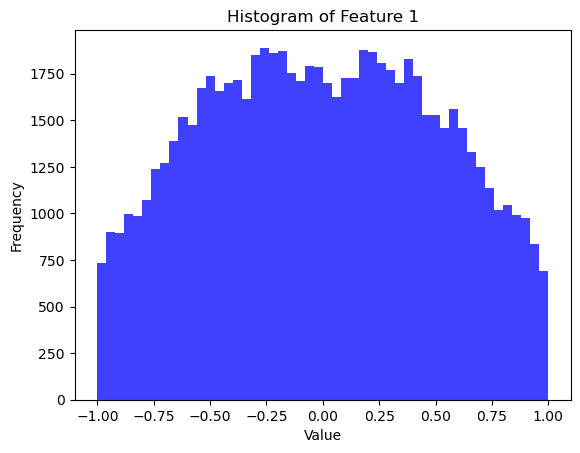

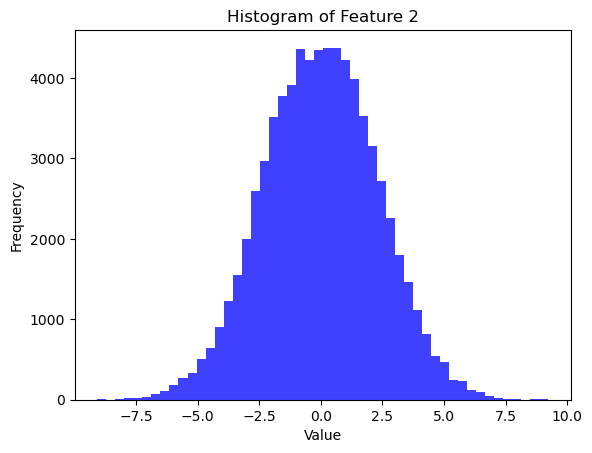

Normalized:


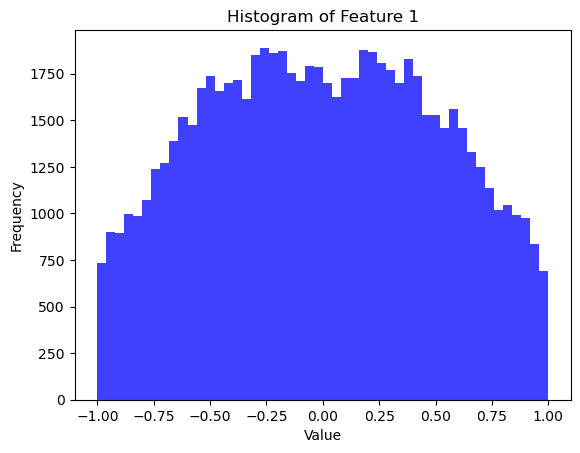

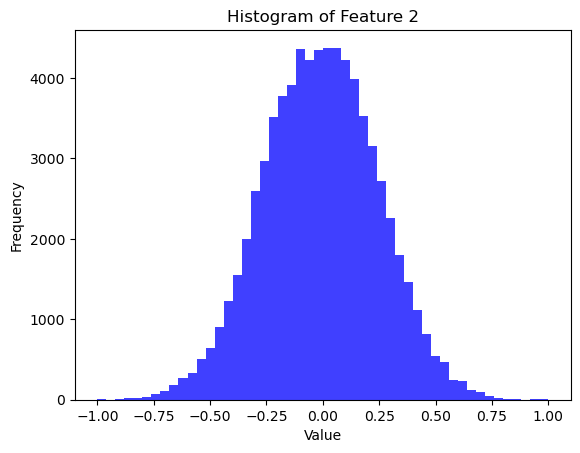

In [3]:
inputs_np, targets_np = ut.process_data(combined_data, dims=dims)

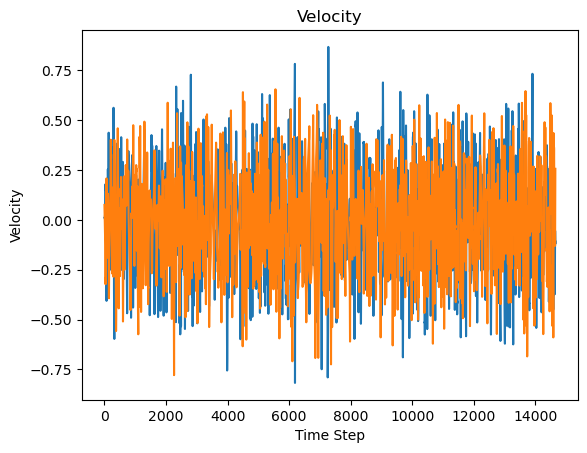

In [4]:
#time_steps = np.arange(mse_values.shape[0])  # Generate an array of time steps
plt.figure()
plt.plot(inputs_np[:, 0, 2:])  # Plot MSE values against time steps

plt.xlabel('Time Step')
plt.ylabel('Velocity')
plt.title('Velocity')
plt.show()

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
from datetime import datetime
import models

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)


activation = 'relu'
mlp_activation = nn.Tanh
particle_dim = 2 * dims  # 3 for position and 3 for velocity
model_dim = 256
num_heads = 4
num_layers = 1
hidden_dims = [256, 256, 256, 256]
lr = 0.001
batch_size = 32
particle_index = 0
precision = 'double'
mlp_type = 'output'
model_dict = {
    'particle_dim': particle_dim,  # 3 for position and 3 for velocity
    'model_dim': model_dim,
    'num_heads': num_heads,
    'num_layers': num_layers,
    'hidden_dims': str(hidden_dims),
    'lr': lr,
    'batch_size': batch_size,
    'activation': activation,
    'precision': precision,
    'mlp_type': mlp_type,
}
hparams.update(model_dict)

#experiment
current_time = datetime.now().strftime('%Y-%m-%d %H:%M')
experiment_folder = f'runs_g_1p_encoder_mlp/{activation}_{current_time}_l1_{str(model_dim)}_{str(num_heads)}_{str(num_layers)}_{str(batch_size)}_{str(lr)}_double_{dims}_{str(hidden_dims).replace("[", "(").replace("]", ")")}_{str(mlp_activation.__name__)}_mlp{mlp_type}'
writer = SummaryWriter(experiment_folder)

np.savez(os.path.join(experiment_folder, 'data_arrays.npz'), inputs=inputs_np, targets=targets_np)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.EncoderWithMLP(particle_dim=particle_dim,
                              model_dim=model_dim,
                              num_heads=num_heads,
                              num_layers=num_layers,
                              particle_index=particle_index,
                              activation=activation,
                              hidden_dims=hidden_dims,
                              mlp_act=nn.ReLU,
                              mlp_type=mlp_type,
                              hparams=hparams                              
                              ).to(device)

inputs_tensor = torch.tensor(inputs_np, dtype=torch.float64)
targets_tensor = torch.tensor(targets_np, dtype=torch.float64)
dataset = TensorDataset(inputs_tensor.to(device).double(), targets_tensor[:, particle_index, :].to(device).double())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 600
epoch = 0

cuda


In [8]:
import importlib
importlib.reload(ut)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch, loss = ut.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=epoch, writer=writer,
                             dims=dims)

Epoch [46/600], avg_both: 0.01692, avg_pos:  0.01210, avg_vel:  0.02174, perc_pos:  3.57430%, perc_vel:  15.75183%
Epoch [47/600], avg_both: 0.01647, avg_pos:  0.01126, avg_vel:  0.02169, perc_pos:  3.37049%, perc_vel:  15.81032%
Epoch [48/600], avg_both: 0.01634, avg_pos:  0.01115, avg_vel:  0.02153, perc_pos:  3.34400%, perc_vel:  15.61750%
Epoch [49/600], avg_both: 0.01634, avg_pos:  0.01097, avg_vel:  0.02171, perc_pos:  3.26029%, perc_vel:  15.79231%
Epoch [50/600], avg_both: 0.01612, avg_pos:  0.01101, avg_vel:  0.02123, perc_pos:  3.26607%, perc_vel:  15.52118%
Epoch [51/600], avg_both: 0.01597, avg_pos:  0.01060, avg_vel:  0.02134, perc_pos:  3.17022%, perc_vel:  15.47493%
Epoch [52/600], avg_both: 0.01605, avg_pos:  0.01052, avg_vel:  0.02159, perc_pos:  3.12078%, perc_vel:  15.78296%
Epoch [53/600], avg_both: 0.01634, avg_pos:  0.01086, avg_vel:  0.02182, perc_pos:  3.25391%, perc_vel:  15.92261%
Epoch [54/600], avg_both: 0.01586, avg_pos:  0.01090, avg_vel:  0.02082, perc_po

In [9]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr * 0.01)
data_loader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)
epoch, loss = ut.train_model(model, optimizer, criterion, data_loader, num_epochs, old_epoch=epoch, writer=writer,
                             dims=dims)

Epoch [63/600], avg_both: 0.01148, avg_pos:  0.00552, avg_vel:  0.01745, perc_pos:  1.78572%, perc_vel:  12.58627%
Epoch [64/600], avg_both: 0.01071, avg_pos:  0.00448, avg_vel:  0.01695, perc_pos:  1.45343%, perc_vel:  12.17632%
Epoch [65/600], avg_both: 0.01049, avg_pos:  0.00428, avg_vel:  0.01670, perc_pos:  1.37846%, perc_vel:  12.07447%
Epoch [66/600], avg_both: 0.01041, avg_pos:  0.00416, avg_vel:  0.01667, perc_pos:  1.34060%, perc_vel:  12.02617%
Epoch [67/600], avg_both: 0.01034, avg_pos:  0.00409, avg_vel:  0.01659, perc_pos:  1.32316%, perc_vel:  11.99462%
Epoch [68/600], avg_both: 0.01028, avg_pos:  0.00402, avg_vel:  0.01653, perc_pos:  1.30100%, perc_vel:  11.94476%
Epoch [69/600], avg_both: 0.01019, avg_pos:  0.00396, avg_vel:  0.01642, perc_pos:  1.28362%, perc_vel:  11.86880%
Epoch [70/600], avg_both: 0.01019, avg_pos:  0.00393, avg_vel:  0.01644, perc_pos:  1.26704%, perc_vel:  11.87949%
Epoch [71/600], avg_both: 0.01015, avg_pos:  0.00390, avg_vel:  0.01640, perc_po

In [14]:
predicted_data = ut.get_predicted_data(model, dataset.tensors[0], particle_index)
import importlib

#%matplotlib qt
importlib.reload(ut)
ut.plot_trajectory(targets_np, predicted_data, particle_index=particle_index, writer=writer, epoch=epoch, dims=dims)

ut.plot_error_over_time_position(targets_np, predicted_data, particle_index, writer=writer, epoch=epoch, dims=dims)
ut.plot_error_over_time_velocity(targets_np, predicted_data, particle_index, writer=writer, epoch=epoch, dims=dims)

ut.log_hparams(writer, hparams, loss.item())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming dims, actual_data are defined
# Extract position and velocity data
position_data = actual_data[:, :, :dims]
velocity_data = actual_data[:, :, dims:]

# Calculate L1 (Manhattan) and L2 (Euclidean) norms for positions and velocities
l1_norm_positions = np.sum(np.abs(position_data), axis=2)
l2_norm_positions = np.linalg.norm(position_data, axis=2)

l1_norm_velocities = np.sum(np.abs(velocity_data), axis=2)
l2_norm_velocities = np.linalg.norm(velocity_data, axis=2)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# L1 Norms
axes[0, 0].hist(l1_norm_positions.flatten(), bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('L1 Norm Distribution of Positions')
axes[0, 0].set_xlabel('L1 Norm')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(l1_norm_velocities.flatten(), bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('L1 Norm Distribution of Velocities')
axes[0, 1].set_xlabel('L1 Norm')
axes[0, 1].set_ylabel('Frequency')

# L2 Norms
axes[1, 0].hist(l2_norm_positions.flatten(), bins=30, alpha=0.7, color='red')
axes[1, 0].set_title('L2 Norm Distribution of Positions')
axes[1, 0].set_xlabel('L2 Norm')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(l2_norm_velocities.flatten(), bins=30, alpha=0.7, color='orange')
axes[1, 1].set_title('L2 Norm Distribution of Velocities')
axes[1, 1].set_xlabel('L2 Norm')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
